In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [111]:
SEED = 42

def set_seed(seed):
    """unchanged from the original code, sets the seed for reproducibility."""

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(SEED)

## Data

<p style="font-size: 14px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example. 
<br>
<ul style="font-size: 14px">
  <li> happiness, Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness, Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral, I just want to Sleep.</li>
</ul>

## Exploration and Preprocessing

In [3]:
# print the first 5 rows of the train data

with open('HW2_data/trainEmotions.csv') as f:

    for idx, line in enumerate(f):
        if idx == 0:  # header row
            continue
        if idx > 5:
            break
        print(line)

happiness,victory for the bulldogs was celebrated by 3 white chocolate cheesecakes  nom nom nom WHATTA FATTYYY

happiness,"@saraLDS Thanks for that, Sara"

happiness,@Tony_Mandarich well welcome back from the dark side!

happiness,"@sai_shediddy lol , you gotta share too"

happiness,"first up, make up for lost time with jelly. Jalan jalan just the 2 of us  and the rollerblading with my pumpkin. Happeh"



In [4]:
def import_data(file_path):
    labels_comments_list = []
    with open(file_path) as f:
        for idx, line in tqdm(enumerate(f)):
            if idx == 0:  # header row
                continue
            if line[:9] == "happiness":
                labels_comments_list.append((1, line[10:]))
            elif line[:7] == "sadness":
                labels_comments_list.append((2, line[8:]))
            else:
                labels_comments_list.append((0, line[8:]))
    return labels_comments_list


train_labels_comments_list = import_data('HW2_data/trainEmotions.csv')
test_labels_comments_list = import_data('HW2_data/testEmotions.csv')

14505it [00:00, 1255279.57it/s]
0it [00:00, ?it/s]

4838it [00:00, 1184867.61it/s]


In [5]:
proportion_happiness = sum([1 for label, comment in train_labels_comments_list if label == 1]
                           ) / len(train_labels_comments_list)
proportion_sadness = sum([1 for label, comment in train_labels_comments_list if label == 2]) / \
    len(train_labels_comments_list)
proportion_neutral = sum([1 for label, comment in train_labels_comments_list if label == 0]) / \
    len(train_labels_comments_list)

proportion_list = [proportion_neutral, proportion_happiness, proportion_sadness]
print(proportion_list)

[0.357280750137893, 0.3743794815223387, 0.26833976833976836]


### Data Preprocessing - Cleaning the reviews

We start by removing the punctuation from the reviews, and then we convert the them to lowercase. We also remove the stopwords, and then we index the words in each review (bag-of-words model). 

We then pad all the reviews to be the same length, and then convert them to sequences of integers.

In [ ]:
from string import punctuation
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


def normalize_data(labels_comments_list):
    """ Normalize the data by removing punctuation and stop words. """
    reviews = [review for label, review in labels_comments_list]
    labels = [label for label, review in labels_comments_list]

    normalized_reviews = []
    normalized_labels = []

    for review, label in zip(reviews, labels):
        normalized_review = []
        for word in review.split():
            stripped_word = word.lower().strip(punctuation)
            if stripped_word not in stopwords.words('english'):
                normalized_review.append(stripped_word)

        if len(normalized_review) > 0:
            normalized_reviews.append(normalized_review)
            normalized_labels.append(label)

    return normalized_reviews, normalized_labels


normalized_train_reviews, train_labels = normalize_data(train_labels_comments_list)
normalized_test_reviews, test_labels = normalize_data(test_labels_comments_list)

In [7]:
for i in range(5):
    print(train_labels_comments_list[i][1])
    print(normalized_train_reviews[i])

victory for the bulldogs was celebrated by 3 white chocolate cheesecakes  nom nom nom WHATTA FATTYYY

['victory', 'bulldogs', 'celebrated', '3', 'white', 'chocolate', 'cheesecakes', 'nom', 'nom', 'nom', 'whatta', 'fattyyy']
"@saraLDS Thanks for that, Sara"

['saralds', 'thanks', 'sara']
@Tony_Mandarich well welcome back from the dark side!

['tony_mandarich', 'well', 'welcome', 'back', 'dark', 'side']
"@sai_shediddy lol , you gotta share too"

['sai_shediddy', 'lol', '', 'gotta', 'share']
"first up, make up for lost time with jelly. Jalan jalan just the 2 of us  and the rollerblading with my pumpkin. Happeh"

['first', 'make', 'lost', 'time', 'jelly', 'jalan', 'jalan', '2', 'us', 'rollerblading', 'pumpkin', 'happeh']


### Data Preprocessing - Using word embeddings

In [8]:
from collections import Counter

all_reviews = normalized_train_reviews + normalized_test_reviews
all_words = [word for review in all_reviews for word in review]


# Build a dictionary that maps words to integers
counts = Counter(all_words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# use the dict to tokenize each review in reviews_split
# store the tokenized reviews in reviews_ints
train_reviews_ints = []
for review_in in normalized_train_reviews:
    train_reviews_ints.append([vocab_to_int[word] for word in review_in])

test_reviews_ints = []
for review_in in normalized_test_reviews:
    test_reviews_ints.append([vocab_to_int[word] for word in review_in])

In [9]:
def pad_features(reviews_ints, seq_length):
    """
    Return features of review_ints, where each review is padded with 0's 
    or truncated to the input seq_length.
    """

    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

# pad all reviews to the length of the longest review in both train and test sets
seq_length = max([max(len(x) for x in train_reviews_ints), max(len(x) for x in test_reviews_ints)])

train_features = pad_features(train_reviews_ints, seq_length=seq_length)
test_features = pad_features(test_reviews_ints, seq_length=seq_length)

print(train_features.shape)

(14500, 30)


In [10]:
# example:
print(normalized_train_reviews[0])
print(train_features[0])

['victory', 'bulldogs', 'celebrated', '3', 'white', 'chocolate', 'cheesecakes', 'nom', 'nom', 'nom', 'whatta', 'fattyyy']
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 2490 8573 4073  120  674  452 5404  991  991  991
 5405 8574]


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(np.array(train_labels)))
test_data = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(np.array(test_labels)))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

*****************************

# Define, Train and Compare 2 Models

In [12]:
# First checking if GPU is available
train_on_gpu = torch.cuda.is_available()

if (train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## Vanila RNN Model

In [13]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis with an RNN layer.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding and RNN layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers,
                          dropout=drop_prob, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # Embeddings and RNN output
        x = x.long()
        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)

        # Get the output of the last time step
        rnn_out = rnn_out[:, -1, :]

        # Dropout and fully-connected layer
        out = self.dropout(rnn_out)
        out = self.fc(out)
        # Sigmoid function
        sig_out = self.sig(out)

        # Return the final output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create a new tensor with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state of RNN
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

        return hidden

#### Our Final RNN Model Settings:

In [14]:
# define the basic model and use it to predict the sentiment of the test data

# Instantiate the model w/ hyperparams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding + our word tokens
output_size = 3
embedding_dim = 200
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# loss and optimization functions
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Training parameters
epochs = 10  # Number of epochs to train for
clip = 5  # Gradient clipping to prevent exploding gradients

# Move model to GPU if available
if train_on_gpu:
    net.cuda()

# Training loop
for e in range(epochs):
    net.train()

    # batch loop
    for inputs, labels in train_loader:
        # Adjust the batch size in case the last batch is smaller
        current_batch_size = inputs.size(0)

        # Initialize hidden state for each new batch
        h = net.init_hidden(current_batch_size)
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Ensure gradient buffers are cleared before each iteration
        net.zero_grad()

        # Forward pass
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

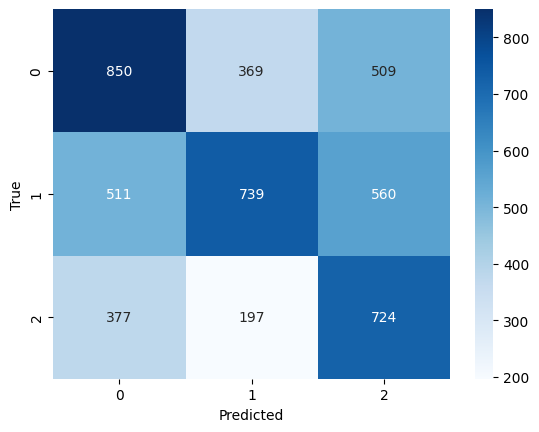

Test accuracy:  0.478287841191067


In [16]:
### Get test data confusion matrix:
net.eval()
preds = []
true = []
for inputs, labels in test_loader:
    current_batch_size = inputs.size(0)  # Correctly get the batch size
    h = net.init_hidden(current_batch_size)  # Initialize hidden state with correct batch size
    if (train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    output, h = net(inputs, h)
    preds += output.squeeze().argmax(dim=1).tolist()
    true += labels.tolist()

mat = confusion_matrix(true, preds)

# plot the confusion matrix
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Report the test accuracy:
print("Test accuracy: ", (np.array(preds) == np.array(true)).mean())

Reminder: 0-happiness, 1-sadness, 2-neutral.

Notice that our model most often confuses sadness with neutral, and also happiness with neutral. This is surprising, because 'neutral' is the least common class but gets predicted most often. We suggest this might be because a neutral tone is harder to distinguish, maybe because happiness and sadness contain more 'information' in word choices. 

## Training and Evaluating the Model with Different Hyper-Parameters:

In [129]:
def eval_RNN_parameters(emb_dim, hid_dim, n_layers, lr, criterion, optimizer, epochs, clip):
    """
    Function to evaluate the RNN model with different hyperparameters.
    """
    # Instantiate the model w/ hyperparams
    vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding + our word tokens
    output_size = 3
    embedding_dim = emb_dim
    hidden_dim = hid_dim
    n_layers = n_layers

    net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

    # loss and optimization functions
    criterion = criterion
    optimizer = optimizer(net.parameters(), lr=lr)

    # Training parameters
    epochs = epochs 
    clip = clip

    # Move model to GPU if available
    if train_on_gpu:
        net.cuda()

    training_losses = []
    training_accuracies = []
    test_losses = []
    test_accuracies = []

    for e in range(epochs):
        net.train()

        # initialize hidden state
        e_loss = 0
        e_acc = 0
        # batch loop
        for inputs, labels in train_loader:
            # Adjust the batch size in case the last batch is smaller
            current_batch_size = inputs.size(0)

            # Initialize hidden state for each new batch
            h = net.init_hidden(current_batch_size)
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Ensure gradient buffers are cleared before each iteration
            net.zero_grad()

            # Forward pass
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            e_loss += loss.item()
            e_acc += (output.squeeze().argmax(dim=1) == labels).float().sum().item()

        # print(f'Epoch: {e+1}/{epochs} - Train loss: {e_loss/len(train_loader.dataset):.6f} - Train accuracy: {e_acc/len(train_loader.dataset):.6f}')
        training_losses.append(e_loss/len(train_loader.dataset))
        training_accuracies.append(e_acc/len(train_loader.dataset))
        # Get test data loss and accuracy
        test_loss = 0
        test_acc = 0
        net.eval()

        for inputs, labels in test_loader:
            current_batch_size = inputs.size(0)  # Correctly get the batch size
            h = net.init_hidden(current_batch_size)  # Initialize hidden state with correct batch size
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            output, h = net(inputs, h)
            test_loss += criterion(output.squeeze(), labels.long()).item()
            test_acc += (output.squeeze().argmax(dim=1) == labels).float().sum().item()

        # print(f'Epoch: {e+1}/{epochs} - Test loss: {test_loss/len(test_loader.dataset):.6f} - Test accuracy: {test_acc/len(test_loader.dataset):.6f}')
        test_losses.append(test_loss/len(test_loader.dataset))
        test_accuracies.append(test_acc/len(test_loader.dataset))

    return training_losses, training_accuracies, test_losses, test_accuracies

In [130]:
def plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string):
    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot train and test loss on the first subplot
    ax1.plot(training_losses, label='Train loss')
    ax1.plot(test_losses, label='Test loss')
    ax1.plot(range(len(training_losses)), [0.0] * len(training_losses), label='Zero loss')
    ax1.set_title('Train and Test Loss per Epoch - ' + parameters_string)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # Plot train and test accuracy on the second subplot
    ax2.plot(training_accuracies, label='Train accuracy')
    ax2.plot(test_accuracies, label='Test accuracy')
    # plot accuracy of 0.47 line
    ax2.plot(range(len(training_accuracies)), [0.47] * len(training_accuracies), label='0.47 accuracy')
    ax2.set_title('Train and Test Accuracy per Epoch - ' + parameters_string)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

##### Trying different parameters:

We define different values for all hyperparams, and create a model for each. The rest of the params are set to our chosen model's parameters (they passed the threshold of 47% accuracy). 

In [131]:
## Define multiple parameters to evaluate:

emb_dim_1 = 200
emb_dim_2 = 300
emb_dim_3 = 100
emb_dim_list = [emb_dim_2, emb_dim_3]

hid_dim_1 = 256
hid_dim_2 = 128
hid_dim_3 = 512
hid_dim_list = [hid_dim_2, hid_dim_3]

n_layers_1 = 2
n_layers_2 = 4
n_layers_3 = 1
n_layers_list = [n_layers_2, n_layers_3]

lr_1 = 0.001
lr_2 = 0.01
lr_3 = 0.0001
lr_list = [lr_2, lr_3]

epochs_1 = 5
epochs_2 = 10
epochs_list = [epochs_2]

clip_1 = 5
clip_2 = 10
clip_list = [clip_2]

criterion_1 = nn.CrossEntropyLoss()
weights = [1 / 0.35728, 1/0.374, 1/0.268]
criterion_2 = nn.CrossEntropyLoss(weight=torch.tensor(weights))
criterion_list = [criterion_2]

optimizer_1 = torch.optim.Adam
optimizer_2 = torch.optim.SGD
optimizer_list = [optimizer_2]

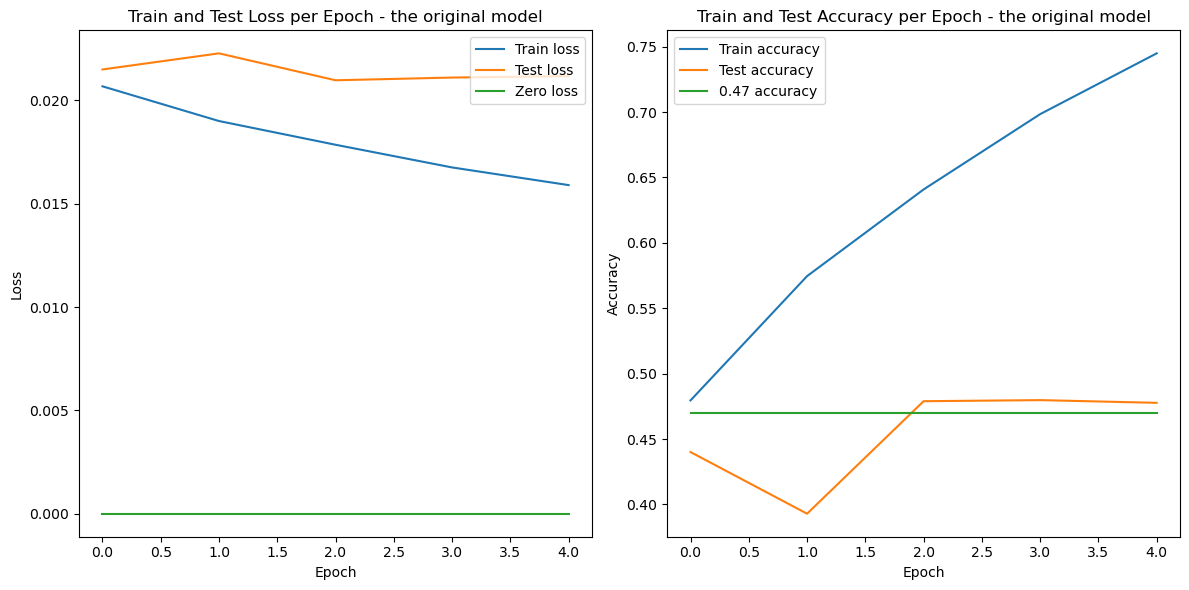

In [132]:
# the original model
training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
parameters_string = f'the original model'
plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

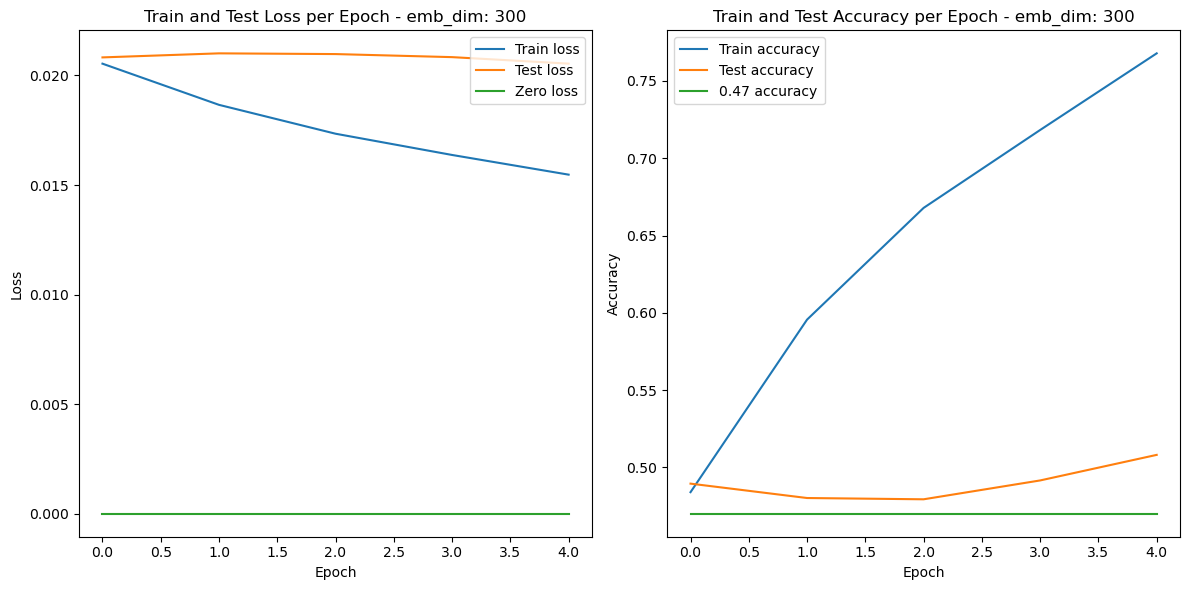

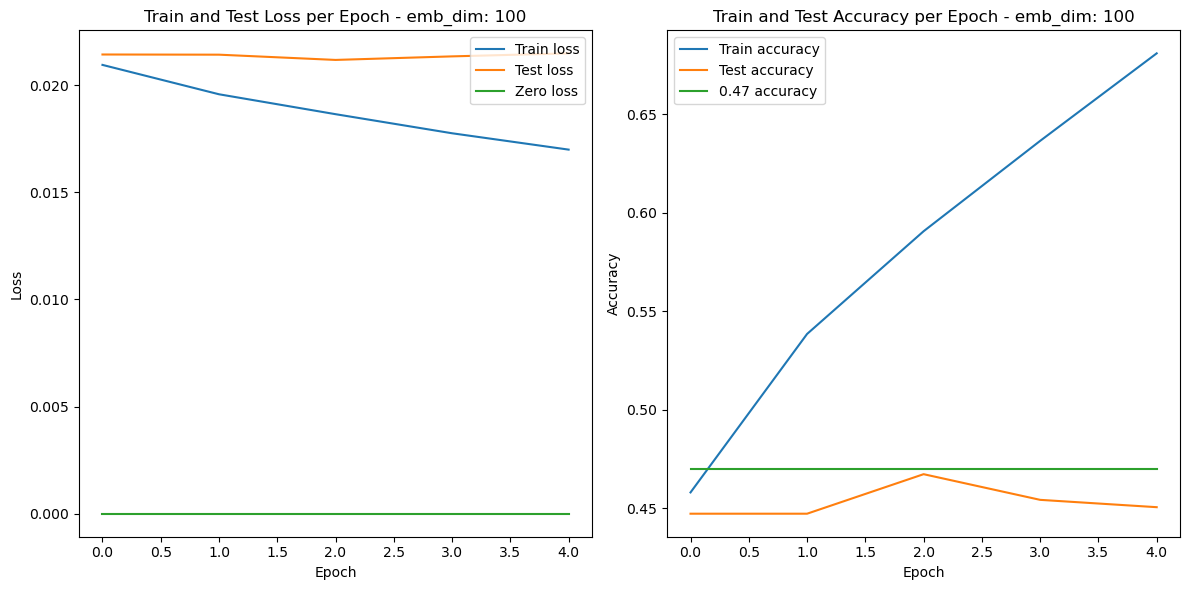

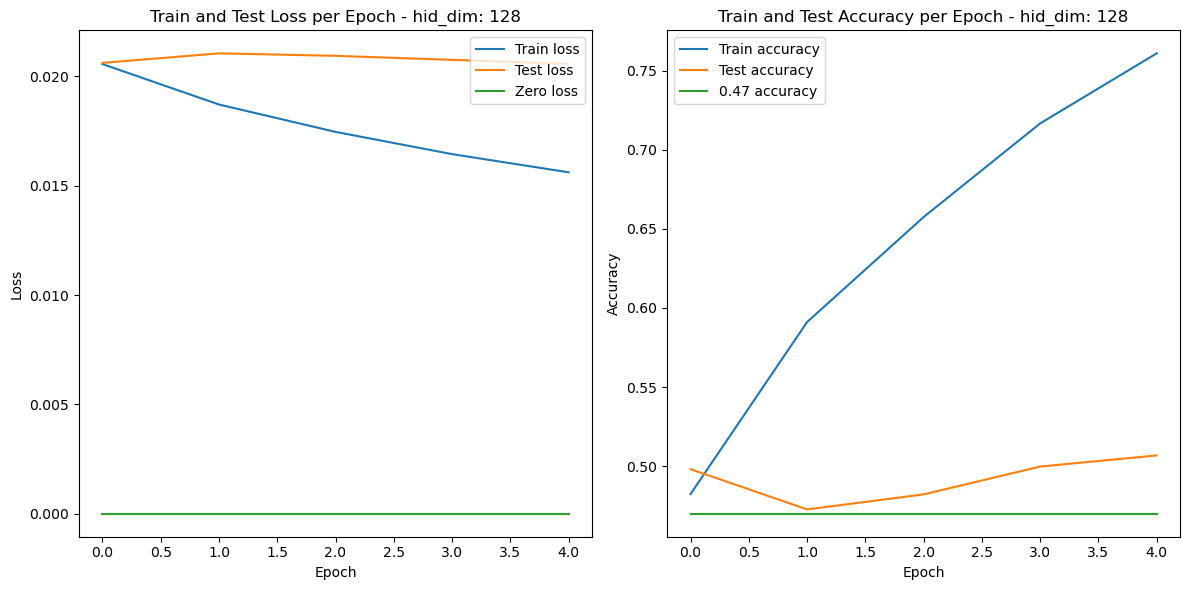

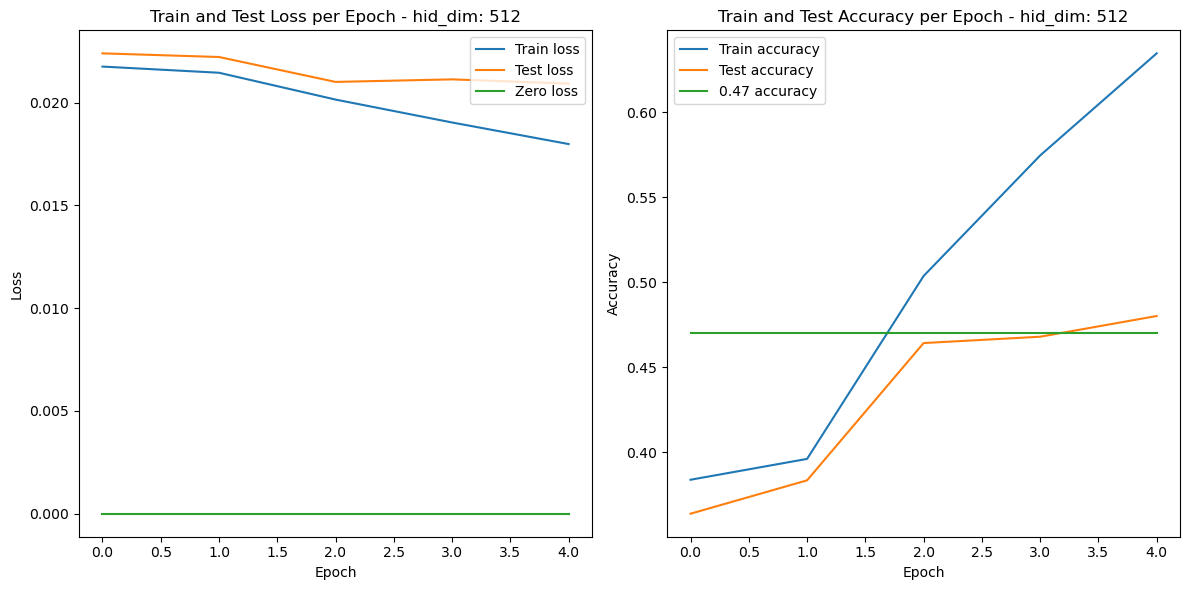

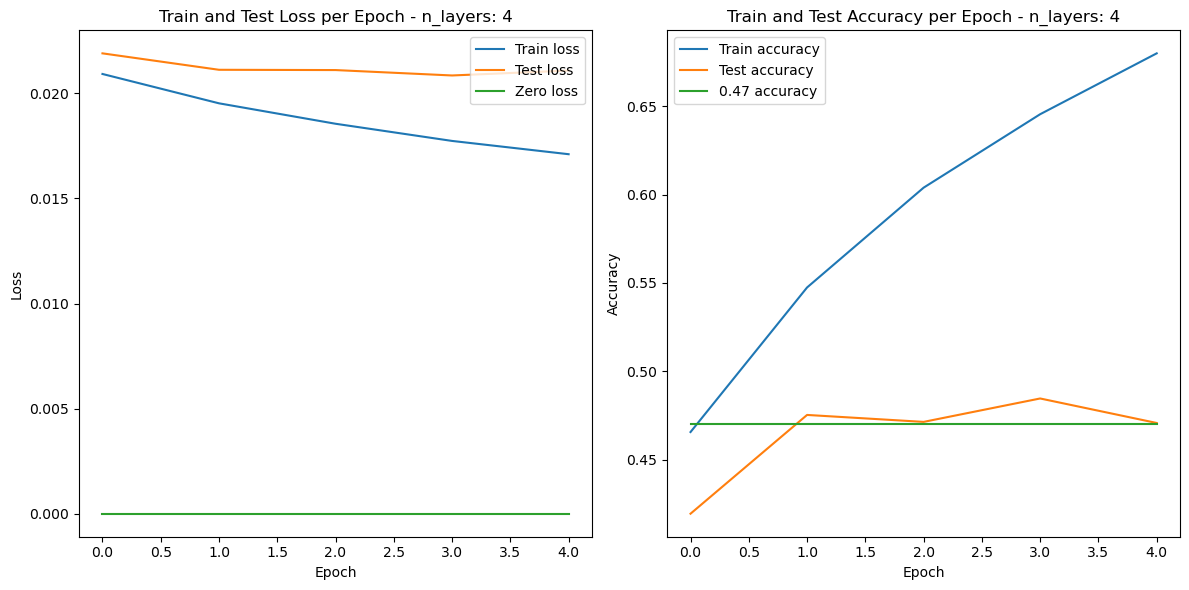

c:\Users\gurgu\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


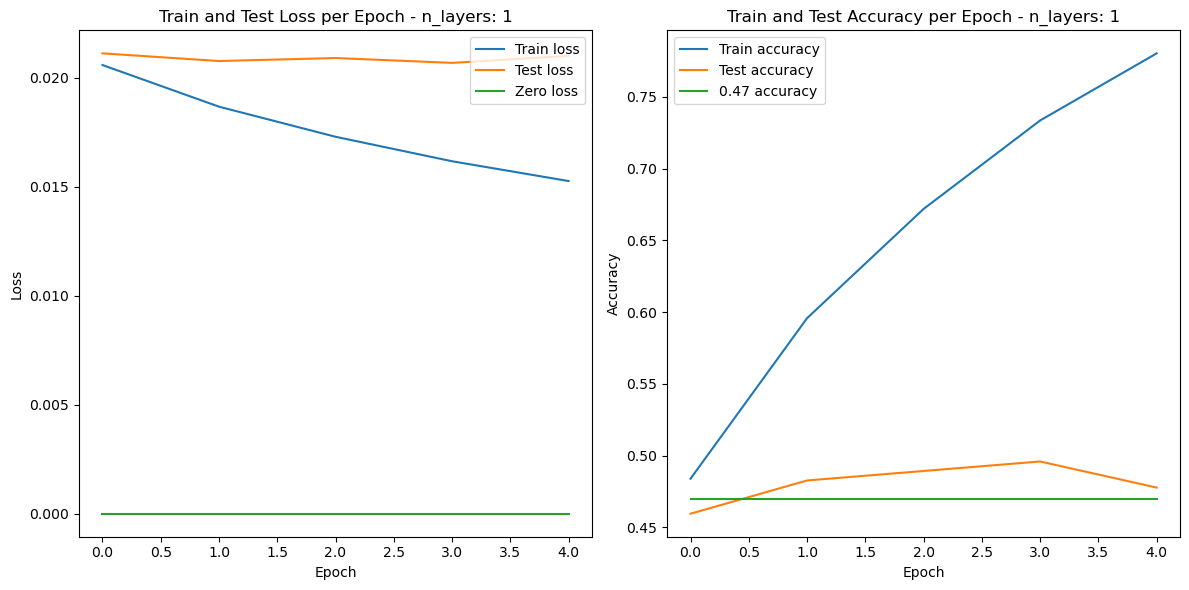

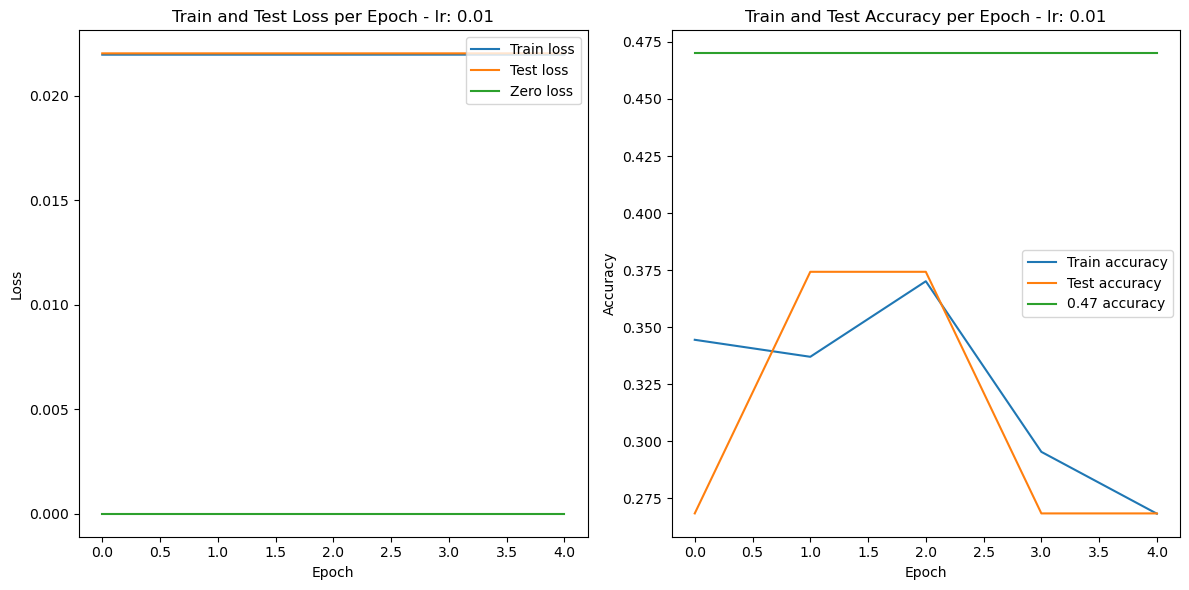

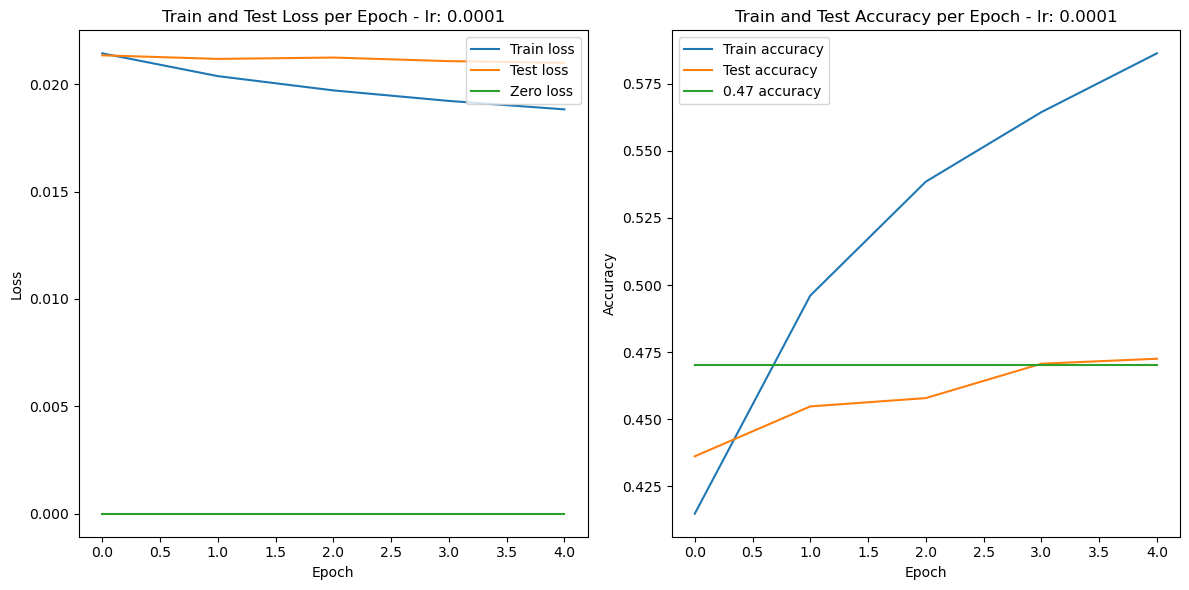

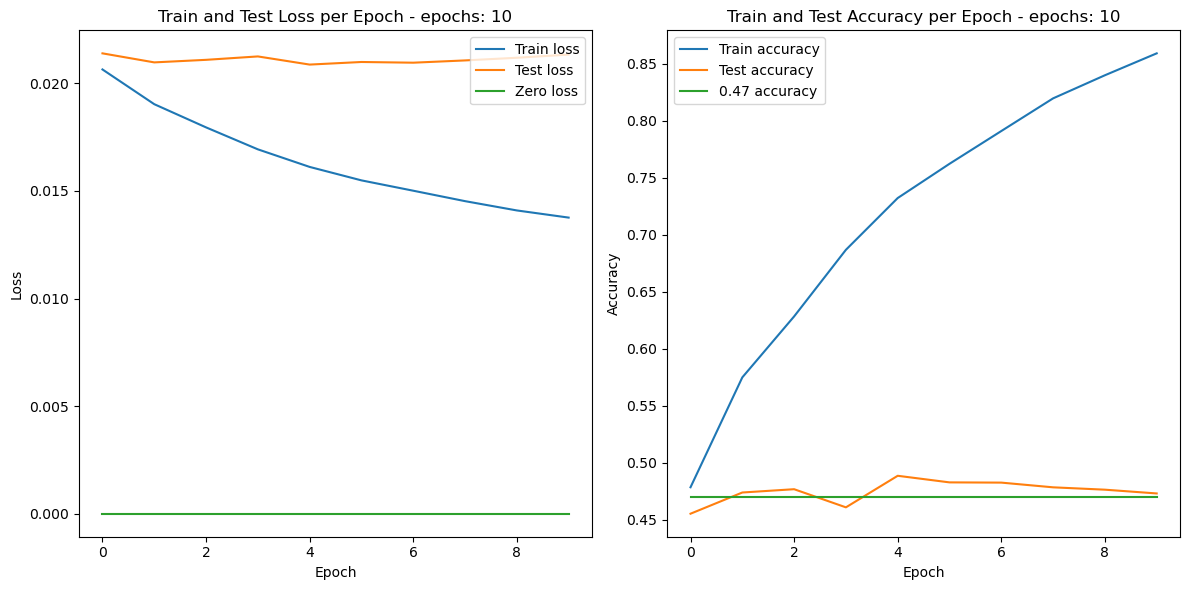

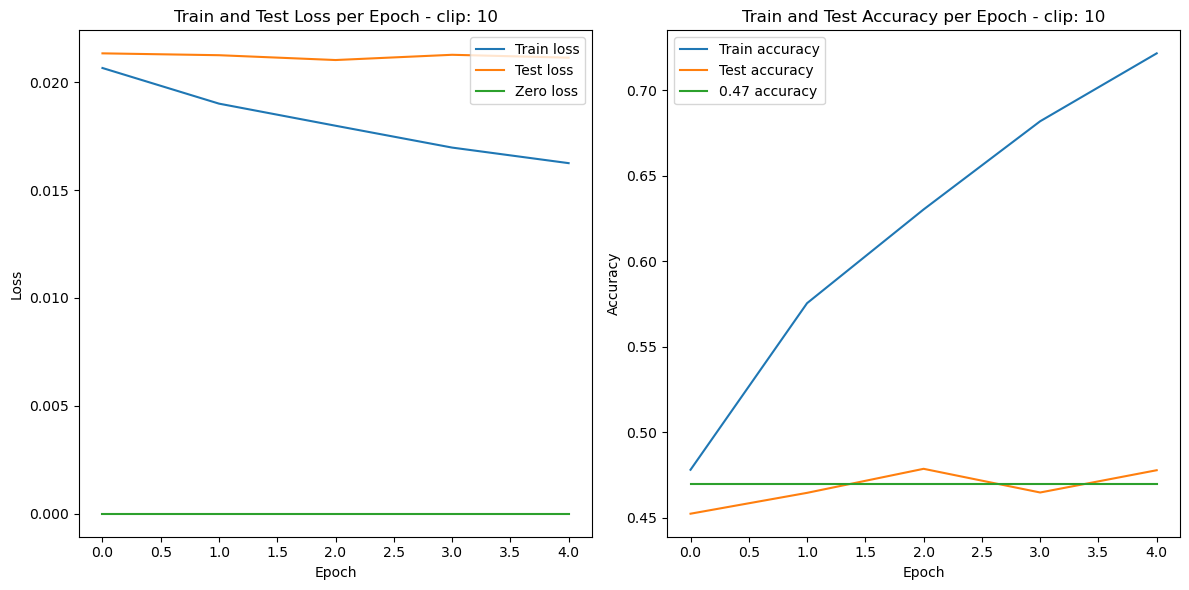

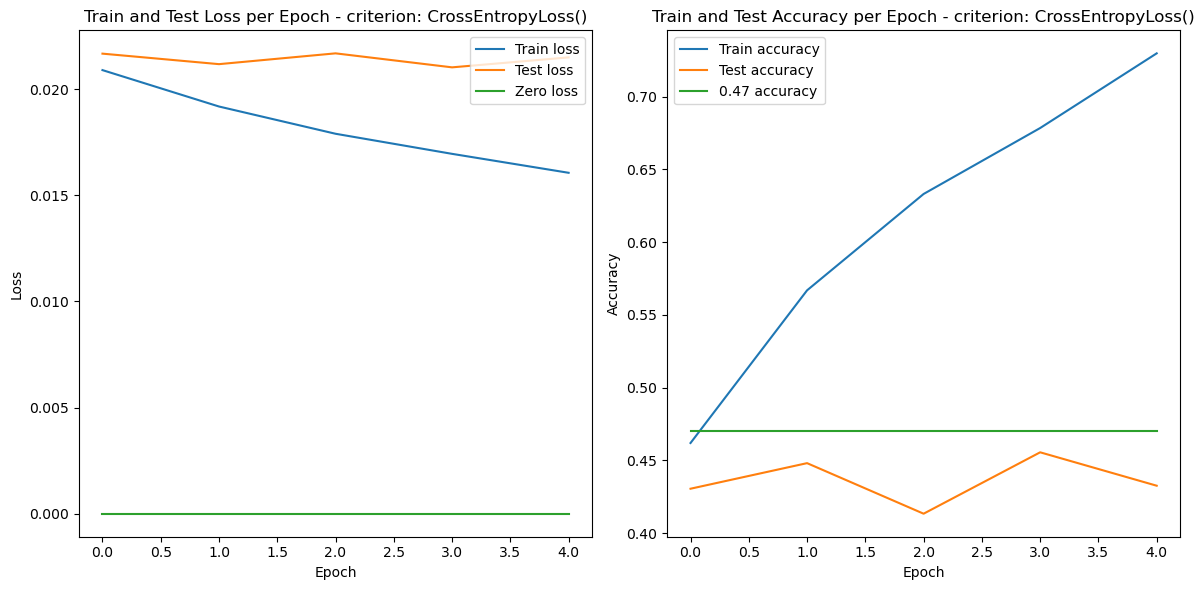

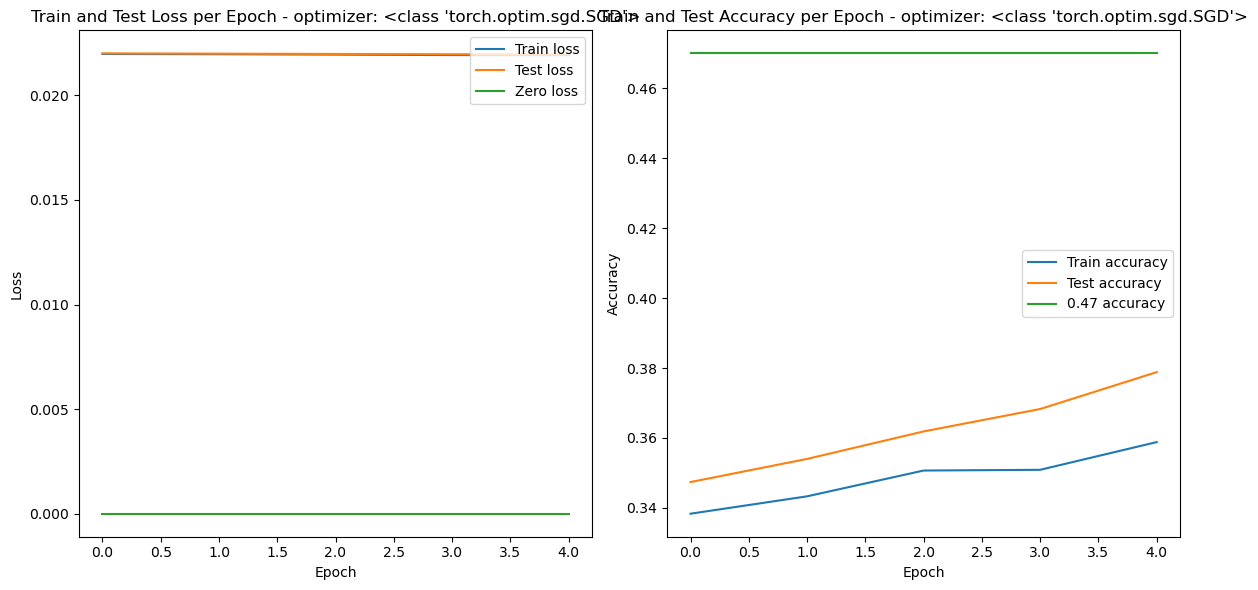

In [133]:
# trying out different emb_dim
for emb_dim in emb_dim_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'emb_dim: {emb_dim}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different hid_dim
for hid_dim in hid_dim_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'hid_dim: {hid_dim}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different n_layers
for n_layers in n_layers_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'n_layers: {n_layers}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different lr
for lr in lr_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'lr: {lr}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different epochs
for epochs in epochs_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs, clip_1)
    parameters_string = f'epochs: {epochs}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different clip
for clip in clip_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip)
    parameters_string = f'clip: {clip}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different criterion
for criterion in criterion_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion, optimizer_1, epochs_1, clip_1)
    parameters_string = f'criterion: {criterion}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different optimizer
for optimizer in optimizer_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_RNN_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer, epochs_1, clip_1)
    parameters_string = f'optimizer: {optimizer}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

### Parameters Impact Discussion

- Embedding dimension:

We found that size of 200 preforms better than 100, which is not enough to capture the textual meaning, but also better than 300 which is too large and might overfit.

- Hidden dimension:

For 128, 256 and 512 hidden dimension sizes, we found that results improve with the size. 128 is barely enough to pass the threshold, 256 is good and the size we eventually picked, and 512 improves the accuracy slightly but causes longer run-time.

- Number of layers:

We tried 1, 2, and 4 layers, and found that more layers improve the accuracy, but not significantly. We chose 2 layers, because it is a good balance between accuracy and run-time.

We noticed that 4-layered models have a lower train accuracy and higher train loss, which might mean that they are capable of better generalization but we didn't find results to support this intuition.

- Learning rate:

We tried 0.01, 0.001, and 0.0001, and found that 0.001 is the best. 0.01 is too large and causes the model to diverge, which causes significantly worse results, and 0.0001 is too small and causes the model to converge too slowly.

- Epochs:

We tried 5 and 10 epochs, and found that more than 5 epochs don't improve the accuracy significantly, and 5 epochs are enough to reach the threshold.

- Clipping:

We tried 5 and 10 gradient clippings, with 10 improving slightly.

- Criterion:

We tried regular cross entropy loss, and also weighted cross entropy loss with inversed label frequency weights. The weights did not improve the results, perhaps because of what we noticed in the confusion matrix - the least common label already is wrongly predicted the most.

- Optimizer:

We tried Adam and SGD, with Adam being significantly better.

## Gated Model - LSTM

In [18]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :]  # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

### Our Final Model Settings:

In [19]:
# define the basic model and use it to predict the sentiment of the test data

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding + our word tokens
output_size = 3
embedding_dim = 200
hidden_dim = 256
n_layers = 2

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# loss and optimization functions
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Training parameters
epochs = 10 
clip = 5

# Move model to GPU if available
if train_on_gpu:
    net.cuda()

net.train()
# Training loop
for e in range(epochs):
    net.train()

    # initialize hidden state
    e_loss = 0
    e_acc = 0
    # batch loop
    for inputs, labels in train_loader:
        current_batch_size = inputs.size(0)
        h = net.init_hidden(batch_size)

        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
            
    # print(f'Epoch: {e+1}/{epochs}')

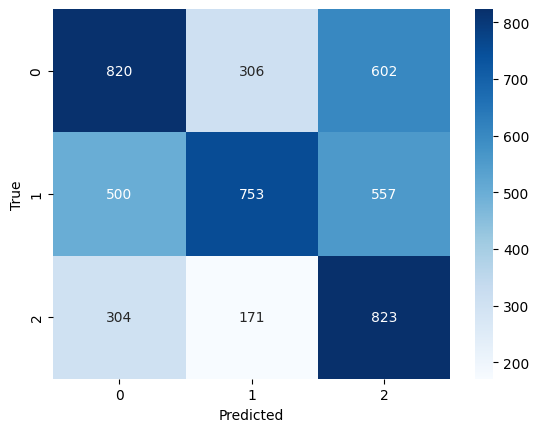

Test accuracy:  0.49545078577336643


In [20]:
### Get test data confusion matrix:
net.eval()
preds = []
true = []

for inputs, labels in test_loader:
    current_batch_size = inputs.size(0)  # Correctly get the batch size
    h = net.init_hidden(current_batch_size)  # Initialize hidden state with correct batch size
    if (train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    output, h = net(inputs, h)
    preds += output.squeeze().argmax(dim=1).tolist()
    true += labels.tolist()

mat = confusion_matrix(true, preds)

# plot the confusion matrix
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Report the test accuracy:
print("Test accuracy: ", (np.array(preds) == np.array(true)).mean())

Reminder: 0-happiness, 1-sadness, 2-neutral.

The results are similar to the RNN, with the neutral output predicted wrongly the most. However, the LSTM mistakes 'neutral' for 'happiness' a bit more than for 'sadness'.

### Training and Evaluating the Model:

In [136]:
def eval_LSTM_parameters(emb_dim, hid_dim, n_layers, lr, criterion, optimizer, epochs, clip):
    """
    Function to evaluate the RNN model with different hyperparameters.
    """
    # Instantiate the model w/ hyperparams
    vocab_size = len(vocab_to_int) + 1  # +1 for the 0 padding + our word tokens
    output_size = 3
    embedding_dim = emb_dim
    hidden_dim = hid_dim
    n_layers = n_layers

    net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

    # loss and optimization functions
    criterion = criterion
    optimizer = optimizer(net.parameters(), lr=lr)

    # Training parameters
    epochs = epochs 
    clip = clip 

    # Move model to GPU if available
    if train_on_gpu:
        net.cuda()

    training_losses = []
    training_accuracies = []
    test_losses = []
    test_accuracies = []

    for e in range(epochs):
        net.train()

        # initialize hidden state
        e_loss = 0
        e_acc = 0
        # batch loop
        for inputs, labels in train_loader:
            current_batch_size = inputs.size(0)
            h = net.init_hidden(batch_size)

            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            e_loss += loss.item()
            e_acc += (output.squeeze().argmax(dim=1) == labels).float().sum().item()

        # print(f'Epoch: {e+1}/{epochs} - Train loss: {e_loss/len(train_loader.dataset):.6f} - Train accuracy: {e_acc/len(train_loader.dataset):.6f}')
        training_losses.append(e_loss/len(train_loader.dataset))
        training_accuracies.append(e_acc/len(train_loader.dataset))
        # Get test data loss and accuracy
        test_loss = 0
        test_acc = 0
        net.eval()

        for inputs, labels in test_loader:
            current_batch_size = inputs.size(0)  # Correctly get the batch size
            h = net.init_hidden(current_batch_size)  # Initialize hidden state with correct batch size
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            output, h = net(inputs, h)
            test_loss += criterion(output.squeeze(), labels.long()).item()
            test_acc += (output.squeeze().argmax(dim=1) == labels).float().sum().item()

        # print(f'Epoch: {e+1}/{epochs} - Test loss: {test_loss/len(test_loader.dataset):.6f} - Test accuracy: {test_acc/len(test_loader.dataset):.6f}')
        test_losses.append(test_loss/len(test_loader.dataset))
        test_accuracies.append(test_acc/len(test_loader.dataset))

    return training_losses, training_accuracies, test_losses, test_accuracies

### Testing Multiple Parameters:

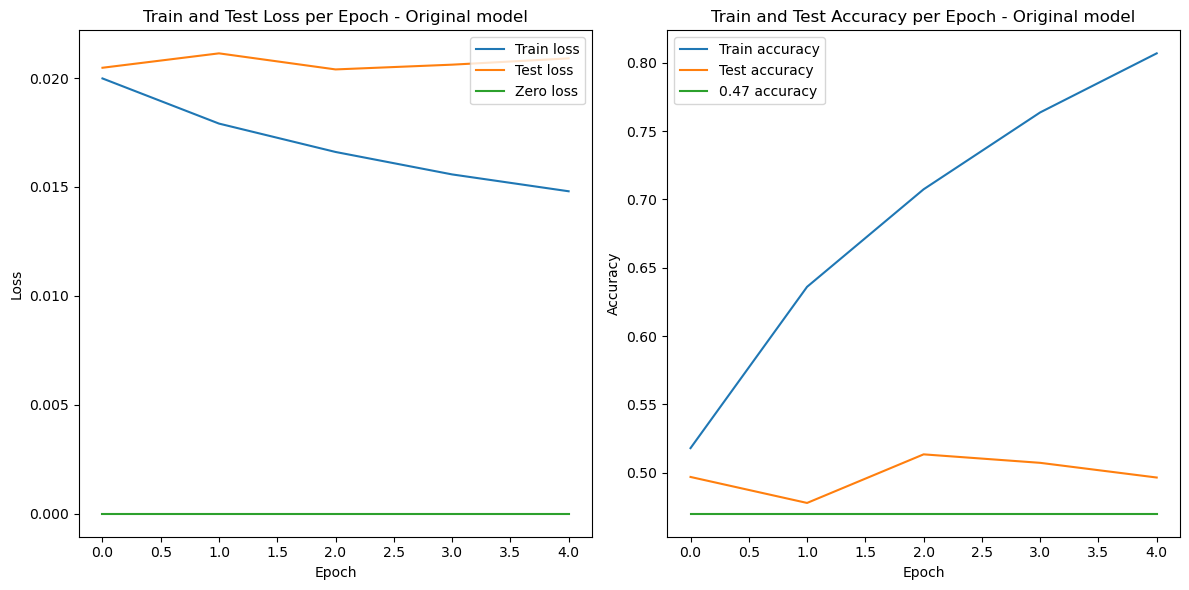

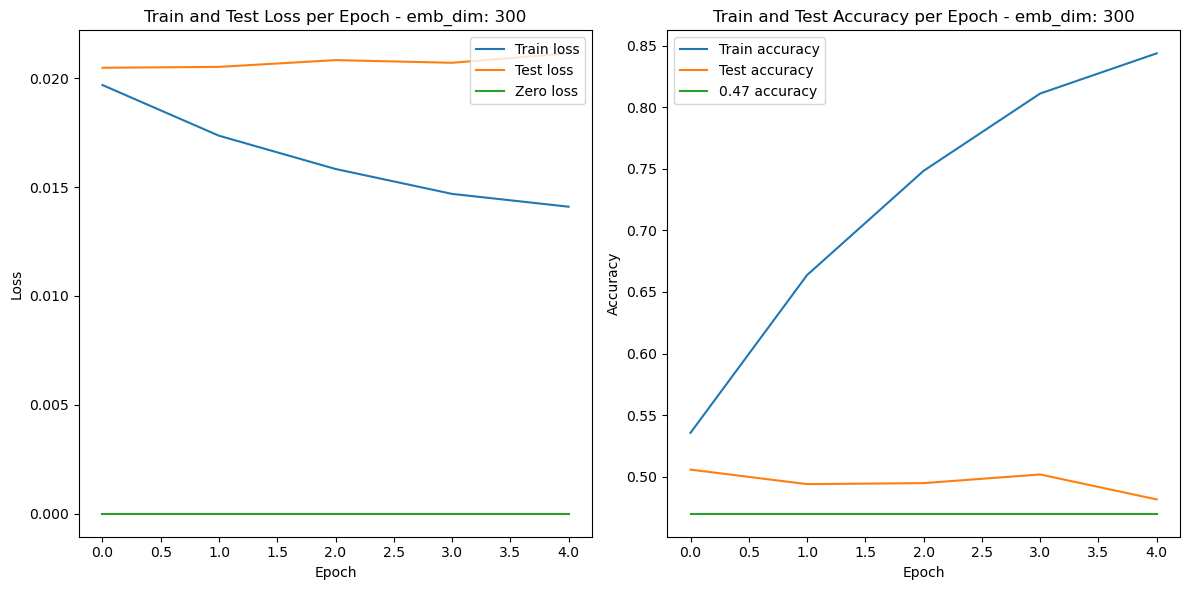

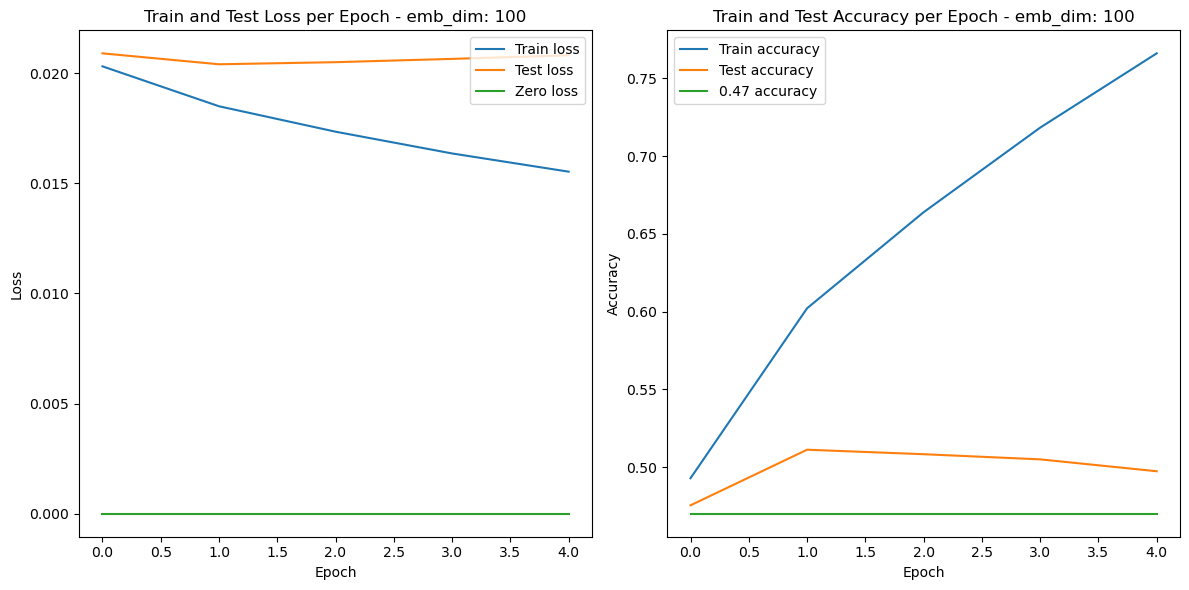

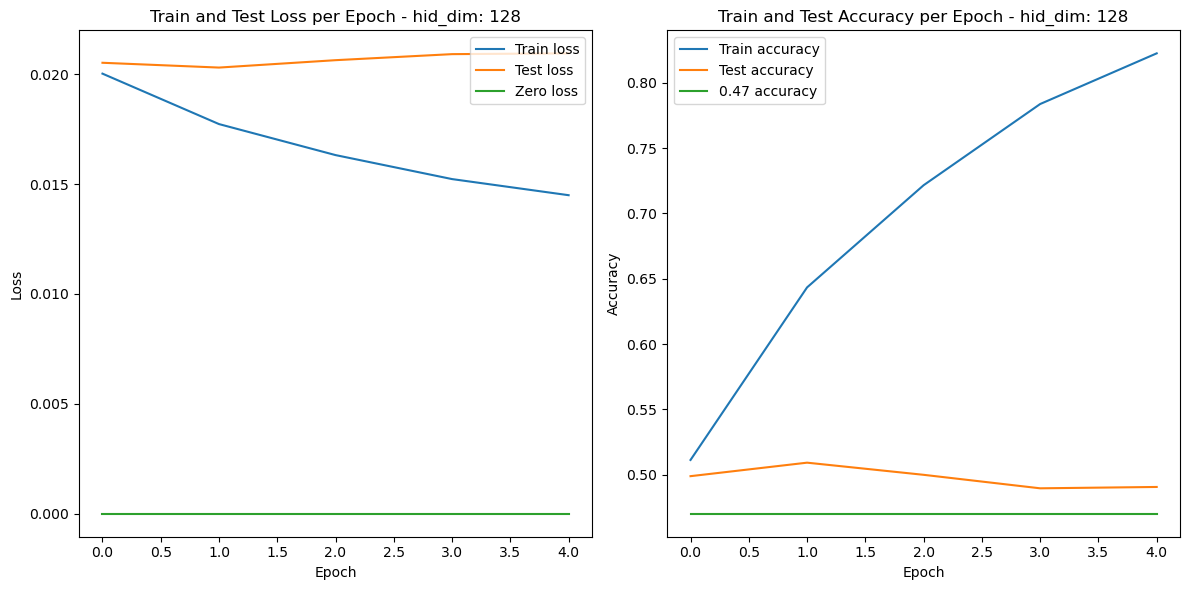

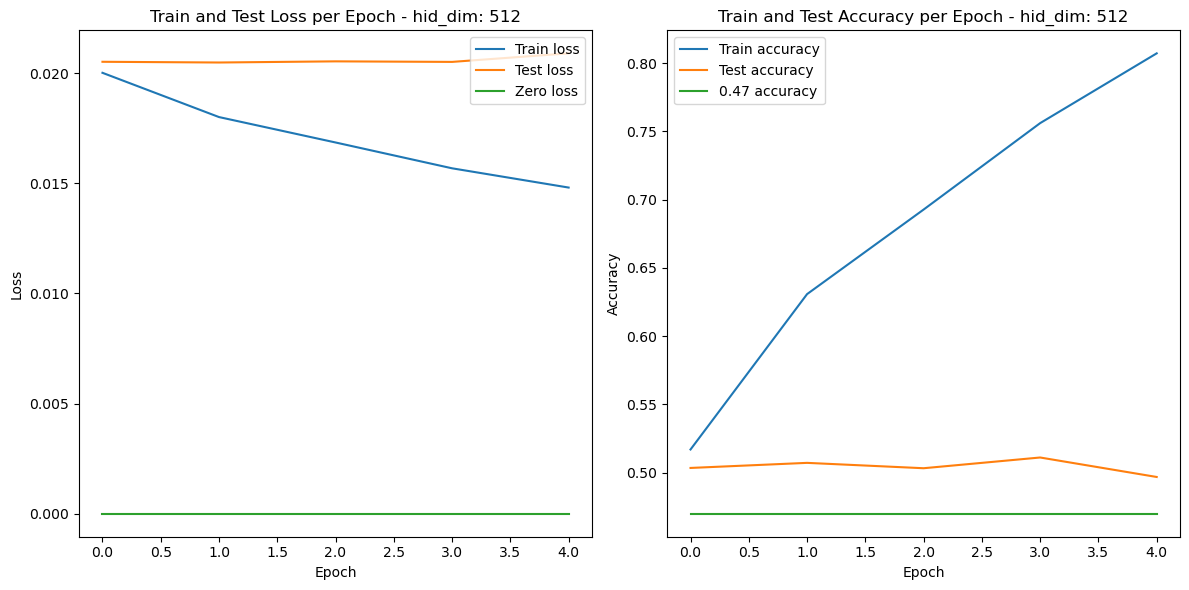

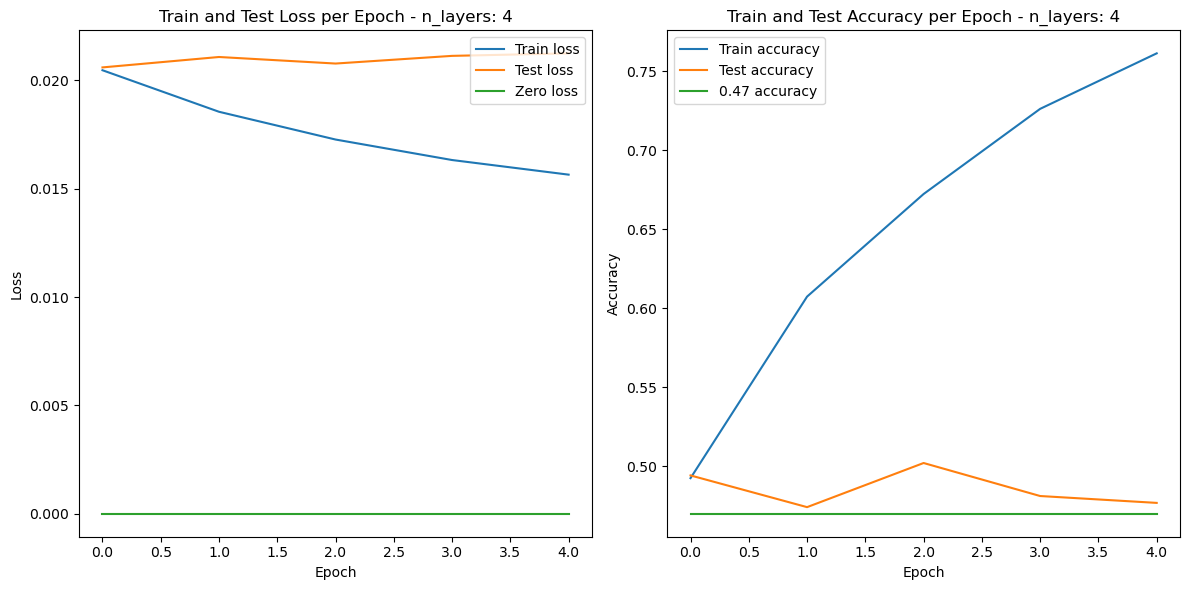

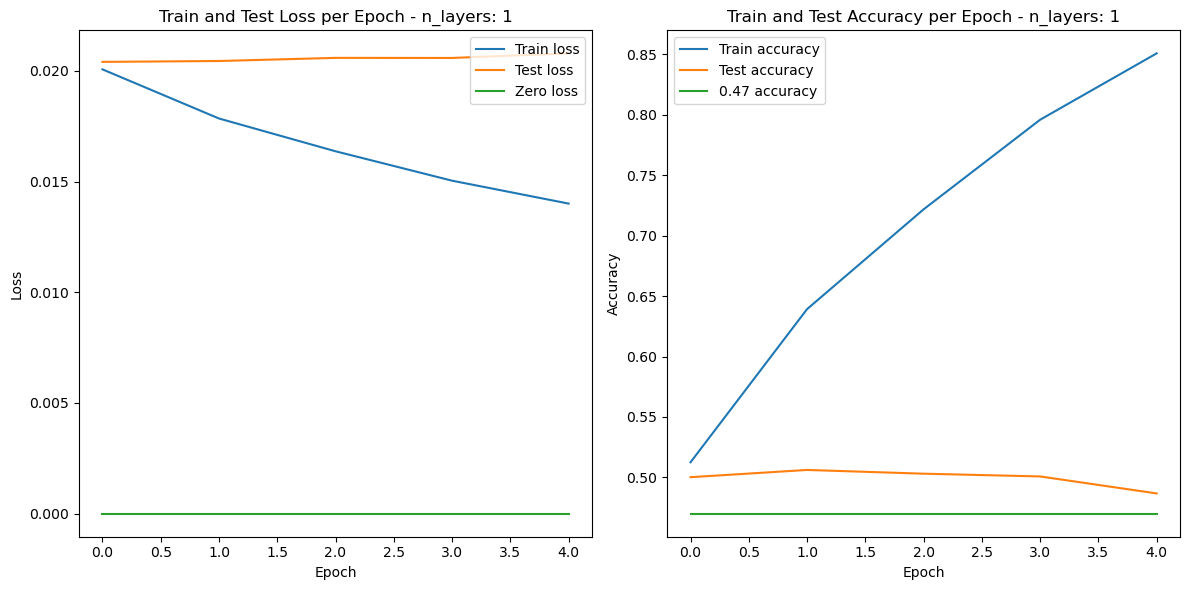

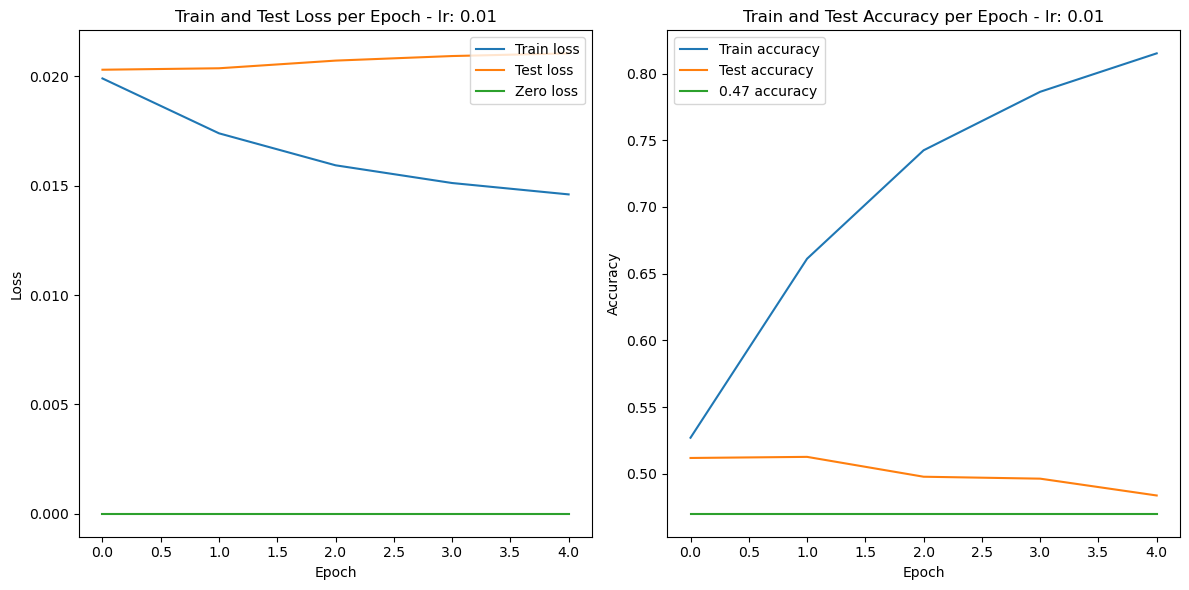

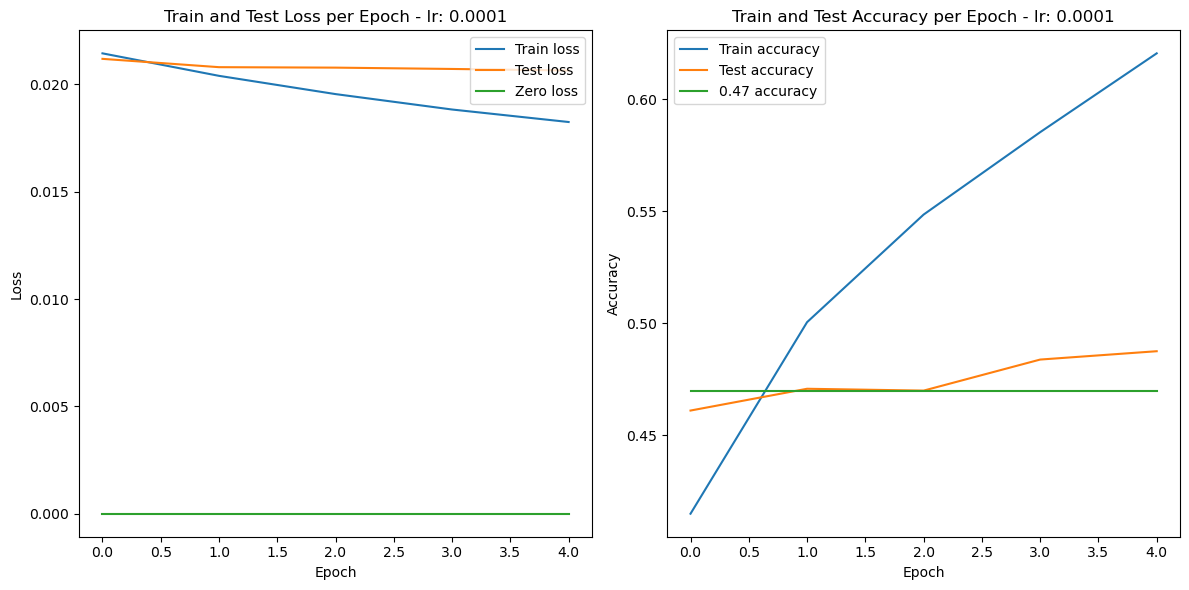

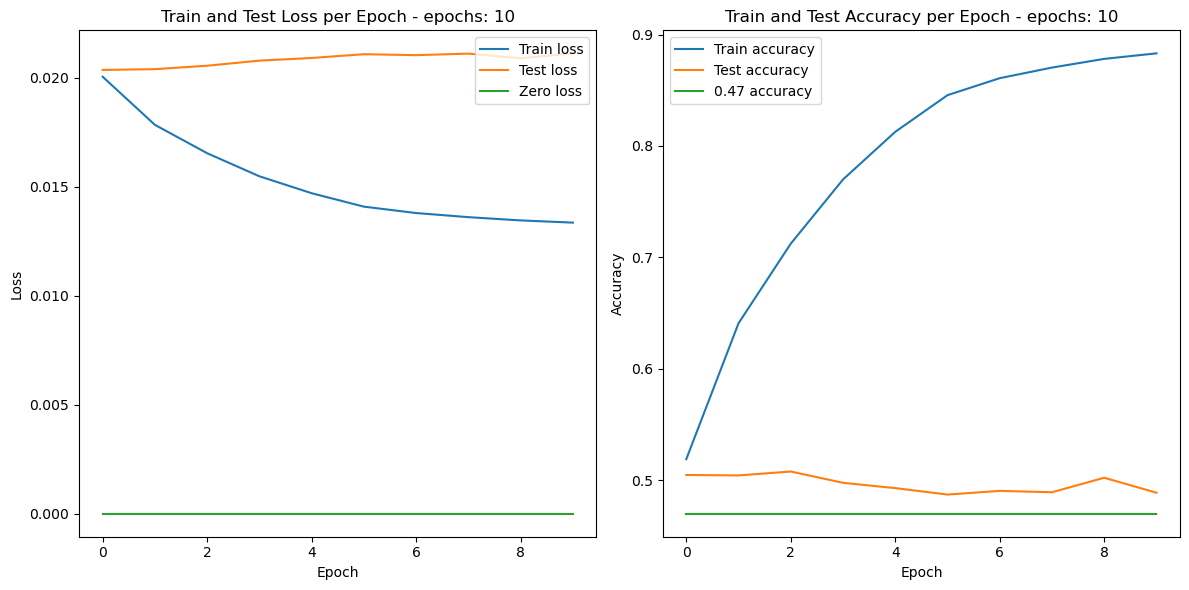

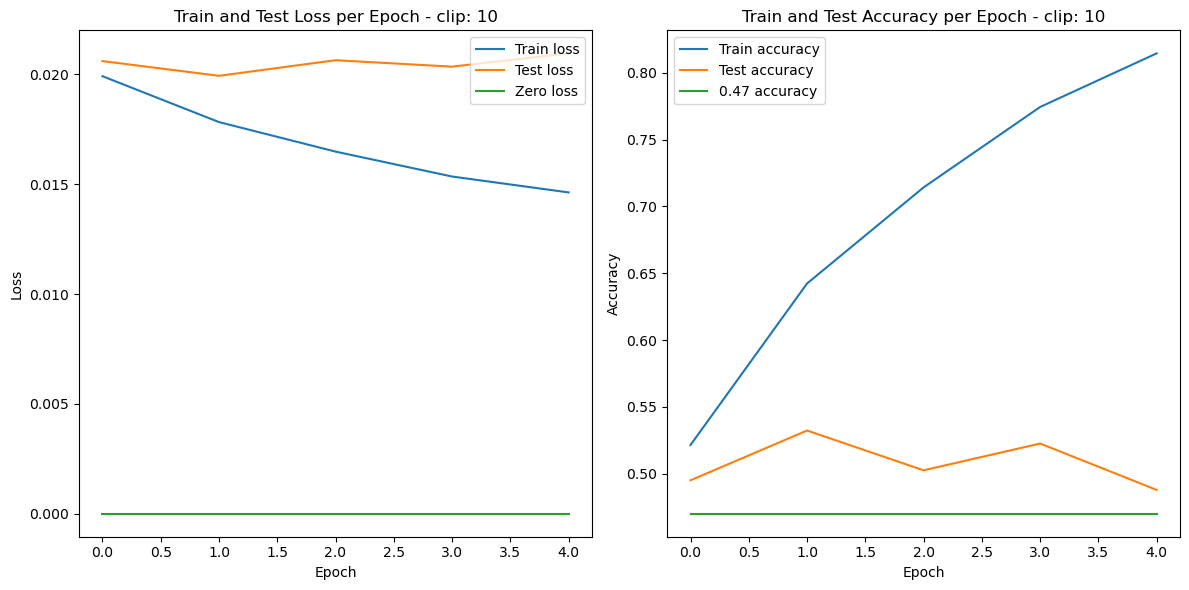

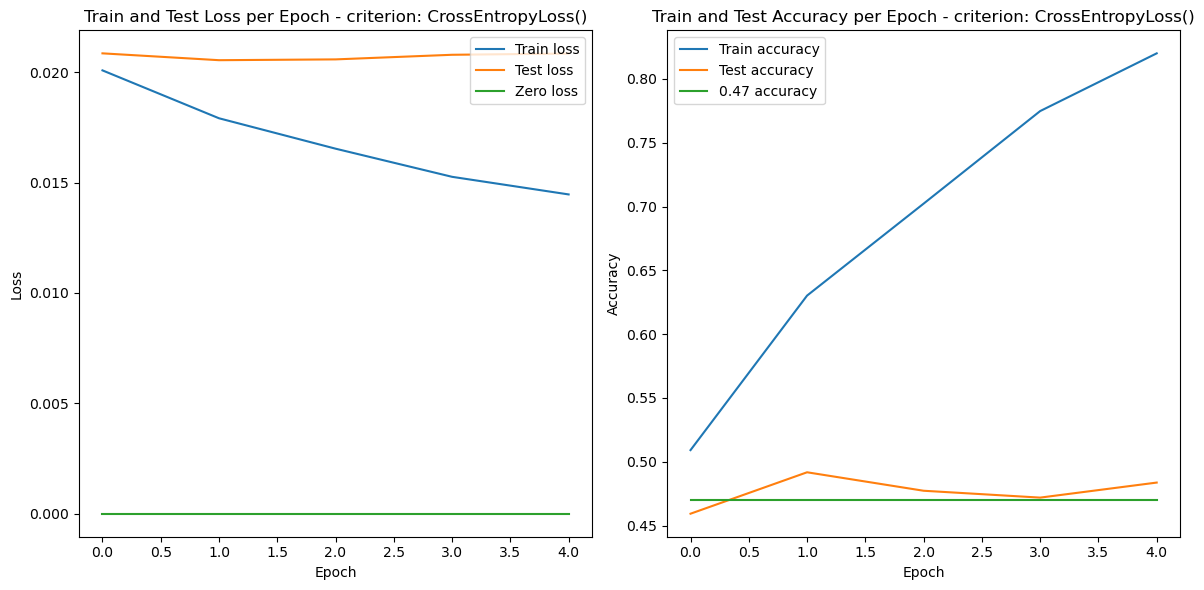

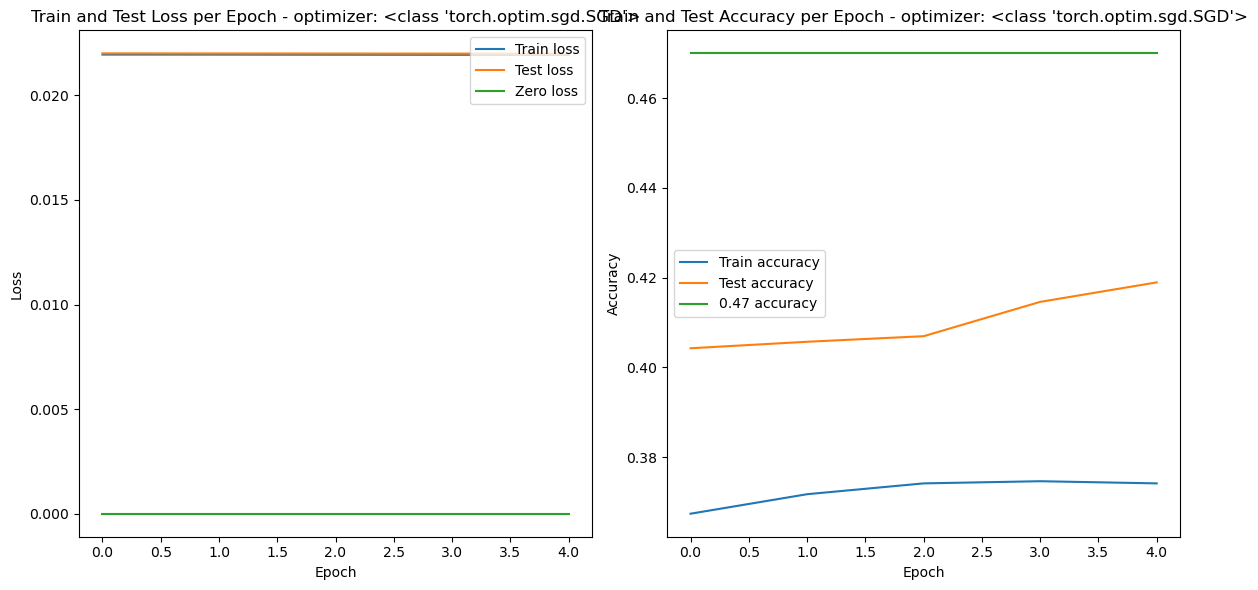

In [137]:
# the original model:
training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
parameters_string = f'Original model'
plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different emb_dim
for emb_dim in emb_dim_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'emb_dim: {emb_dim}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different hid_dim
for hid_dim in hid_dim_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'hid_dim: {hid_dim}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different n_layers
for n_layers in n_layers_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers, lr_1, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'n_layers: {n_layers}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different lr
for lr in lr_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr, criterion_1, optimizer_1, epochs_1, clip_1)
    parameters_string = f'lr: {lr}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different epochs
for epochs in epochs_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs, clip_1)
    parameters_string = f'epochs: {epochs}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different clip
for clip in clip_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer_1, epochs_1, clip)
    parameters_string = f'clip: {clip}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# trying out different criterion
for criterion in criterion_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion, optimizer_1, epochs_1, clip_1)
    parameters_string = f'criterion: {criterion}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

# # trying out different optimizer
for optimizer in optimizer_list:
    training_losses, training_accuracies, test_losses, test_accuracies = eval_LSTM_parameters(
        emb_dim_1, hid_dim_1, n_layers_1, lr_1, criterion_1, optimizer, epochs_1, clip_1)
    parameters_string = f'optimizer: {optimizer}'
    plot_results(training_losses, training_accuracies, test_losses, test_accuracies, parameters_string)

### Parameters impact discussion

- Embedding dimension:

We found that size of 200 preforms better than 100, which is worse at capturing the textual meaning, but also better than 300 which is too large and might overfit.
All in all, they were all good enough to pass the threshold.

- Hidden dimension:

For 128, 256 and 512 hidden dimension sizes, we found the best result for 256. 128 and 512 were enough to pass the threshold, but 256 was the best.

- Number of layers:

We tried 1, 2, and 4 layers, and found that 2 layers were best, with 4 causing slightly worse results and 1 being worse than both.

- Learning rate:

We tried 0.01, 0.001, and 0.0001, and found all were okay but that 0.001 is the best.

- Epochs:

We tried 5 and 10 epochs, and found that more than 5 epochs didn't improve the accuracy and even caused more overfitting - with 10 epochs the train accuracy was 0.9 and the test accuracy got worse.

- Clipping:

We tried 5 and 10 gradient clippings, with 10 improving slightly.

- Criterion:

We tried regular cross entropy loss, and also weighted cross entropy loss with inversed label frequency weights. The weights did not improve the results, perhaps because of what we noticed in the confusion matrix - the least common label already is wrongly predicted the most.

- Optimizer:

We tried Adam and SGD, with Adam being significantly better.

*****************************

## Conclusions

First, inspired by the NLP course methodologies, we tried using GloVe embeddings in a naive way, which didn't work. Looking back, we think that if we were to clean the data then like we are doing now, it might have resulted in a better performance. 

After that, we tried to use the embedding layer that is built in the PyTorch library. This still didn't work, so we tried to clean the data from the punctuation and the stopwords. We then indexed the words and converted the reviews to sequences of integers. This combined with the padding of the reviews to the same length achieved the desired accuracy threshold. 

This method of preprocessing succeeded in both the RNN and LSTM models, and we were able to achieve the desired accuracy threshold.

For each model, we tested different values for most hyperparameters, and found that the best results were:
| Model | Test Accuracy |
| --- | --- |
| RNN | 0.478287841191067 |
| LSTM | 0.49545078577336643 |


*****************************